In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import combinations_with_replacement
print(__doc__)
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set()
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
almost_black = '#262626'
palette = sns.color_palette()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut

np.random.seed(7) 

Automatically created module for IPython interactive environment


In [4]:
def compute_rolling_covariance(df, properties, window_size, center=True):
    combs = combinations_with_replacement(properties, 2)
    
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        well_frame = df[df["Well Name"] == well_n].copy()
        for first_prop, second_prop in combs:
            prop_str = first_prop+"_"+second_prop+"_cov_"+str(window_size)
            well_frame[prop_str] = well_frame[first_prop].rolling(window_size, min_periods=1, center=center).cov(well_frame[second_prop]).bfill().ffill()
            well_frame[prop_str].astype(np.float64).fillna(0)
        well_frames.append(well_frame)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

def compute_rolling_min_max_mean_quantile(df, properties, window_size, center=True):
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        well_frame = df[df["Well Name"] == well_n].copy()
        for prop in properties:
            well_frame[prop+"_mean"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).mean().bfill().ffill()
            well_frame[prop+"_min"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).min().bfill().ffill()
            well_frame[prop+"_max"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).max().bfill().ffill()
            well_frame[prop+"_10q"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).quantile(0.1).bfill().ffill()
            well_frame[prop+"_90q"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).quantile(0.9).bfill().ffill()
            well_frame[prop+"_mean"] = well_frame[prop+"_mean"].astype(np.float64).fillna(0)
            well_frame[prop+"_min"] = well_frame[prop+"_min"].astype(np.float64).fillna(0)
            well_frame[prop+"_max"] = well_frame[prop+"_max"].astype(np.float64).fillna(0)
            well_frame[prop+"_10q"] = well_frame[prop+"_10q"].astype(np.float64).fillna(0)
            well_frame[prop+"_90q"] = well_frame[prop+"_90q"].astype(np.float64).fillna(0)
            
        well_frames.append(well_frame)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

def tsfresh_well_by_well(df, extraction_settings):
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        
        well_frame = df[df["Well Name"] == well_n].copy()
        well_frame["MD"] = well_frame["Depth"]-np.min(well_frame["Depth"])
        well_frame_data = well_frame[well_frame.columns.difference(["Well Name", "Formation", "EOD_Classifier", "Facies"])]
        X = extract_features(well_frame_data, column_id="MD", feature_extraction_settings=extraction_settings)
        well_frames.append(X)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

In [5]:
validation_data = pd.read_csv("../training_data.csv")
#validation_data = validation_data[(validation_data["Well Name"] != "NOLAN")]
validation_data["EOD_Classifier"] = validation_data["Facies"] < 4

In [6]:
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)


validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)

validation_data_marine = validation_data[validation_data["EOD_Classifier"] == False]
validation_data_non_marine = validation_data[validation_data["EOD_Classifier"] == True]

print(set(validation_data[validation_data["EOD_Classifier"]==False]["Facies"]))
print(set(validation_data_marine["Facies"]))
                                 
print(set(validation_data[validation_data["EOD_Classifier"]==True]["Facies"]))
print(set(validation_data_non_marine["Facies"]))


(3232, 33)
(3232, 54)
(3232, 75)
(3232, 96)
(3232, 117)
(3232, 138)
(3232, 159)
(3232, 180)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
{4, 5, 6, 7, 8, 9}
{4, 5, 6, 7, 8, 9}
{1, 2, 3}
{1, 2, 3}


In [7]:
validation_data_marine_numerics = validation_data_marine[validation_data_marine.columns.difference(["Well Name", "Formation", "Facies", "Depth", "EOD_Classifier"])]
validation_data_non_marine_numerics = validation_data_non_marine[validation_data_non_marine.columns.difference(["Well Name", "Formation", "Facies", "Depth", "EOD_Classifier"])]

validation_data_marine_facies = validation_data_marine["Facies"]-np.min(validation_data_marine["Facies"])
validation_data_non_marine_facies = validation_data_non_marine["Facies"]-np.min(validation_data_non_marine["Facies"])

#Define Scalers
marine_scaler = preprocessing.StandardScaler().fit(validation_data_marine_numerics)
non_marine_scaler =  preprocessing.StandardScaler().fit(validation_data_non_marine_numerics)

X_marine_train = marine_scaler.transform(validation_data_marine_numerics)
y_marine_train = np_utils.to_categorical((validation_data_marine_facies).values, nb_classes=len(set(validation_data_marine_facies)))

X_non_marine_train = non_marine_scaler.transform(validation_data_non_marine_numerics)
y_non_marine_train = np_utils.to_categorical((validation_data_non_marine_facies).values, nb_classes=len(set(validation_data_non_marine_facies)))

print(X_marine_train.shape)
print(y_marine_train.shape)

print(X_non_marine_train.shape)
print(y_non_marine_train.shape)

(1620, 205)
(1620, 6)
(1612, 205)
(1612, 3)


In [8]:
def get_dnn_model(in_size, out_size):
    def facies_dnn_model(input_dim=in_size, output_dim=out_size):
        # Define the model
        model = Sequential()
        model.add(Dense(32, input_dim=input_dim, init='normal', activation='relu'))
        model.add(Dense(64, input_dim=32, init='normal', activation='relu'))
        model.add(Dense(32, input_dim=32, init='normal', activation='relu'))
        model.add(Dense(output_dim, init='normal', activation='softmax'))
        if output_dim > 2:
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        else:
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    return facies_dnn_model

input_dim = validation_data_marine_numerics.shape[1]

marine_model = get_dnn_model(input_dim, len(set(validation_data_marine_facies)))

non_marine_model = get_dnn_model(input_dim, len(set(validation_data_non_marine_facies)))

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
epochs=1
scores = []
for train, test in logo.split(X_non_marine_train, y_non_marine_train, groups=validation_data_non_marine["Well Name"]):
    print(train.shape[0]+test.shape[0])
    X_train, X_test = X_non_marine_train[train], X_non_marine_train[test]
    y_train, y_test = y_non_marine_train[train], y_non_marine_train[test]
    
    dnn = non_marine_model()
    dnn.fit(X_train, y_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_test, y_test))
    
    y_marine_predicted = dnn.predict(X_test, batch_size=1, verbose=1)
    conf_pred_marine = confusion_matrix(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1))
    scores.append(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(conf_pred_marine)
    
print(scores)
print(np.min(scores), np.max(scores), np.mean(scores), np.std(scores))

1612
Train on 1497 samples, validate on 115 samples
Epoch 1/1
114/115 [============================>.] - ETA: 0s0.623547101449
[[ 0  3  5]
 [ 8 53 33]
 [ 0  0 13]]
1612
Train on 1265 samples, validate on 347 samples
Epoch 1/1
342/347 [============================>.] - ETA: 0s0.265119620777
[[  0   0   0]
 [142  19   2]
 [ 16 123  45]]
1612


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Train on 1366 samples, validate on 246 samples
Epoch 1/1
246/246 [==============================] - 0s     
0.519331322619
[[  0  13   3]
 [  0  96 109]
 [  0   8  17]]
1612


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 1434 samples, validate on 178 samples
Epoch 1/1
172/178 [===========================>..] - ETA: 0s0.649541691307
[[81 49]
 [17 31]]
1612
Train on 1422 samples, validate on 190 samples
Epoch 1/1
190/190 [==============================] - 0s     
0.584592081296
[[ 0 12  1]
 [ 4 53  8]
 [ 0 53 59]]
1612
Train on 1317 samples, validate on 295 samples
Epoch 1/1
290/295 [============================>.] - ETA: 0s0.559505650214
[[81 38 41]
 [ 8 51 71]
 [ 0  0  5]]
1612
Train on 1371 samples, validate on 241 samples
Epoch 1/1
239/241 [============================>.] - ETA: 0s0.719142634495
[[77 27]
 [41 96]]
[0.62354710144927528, 0.26511962077701201, 0.51933132261870341, 0.64954169130691908, 0.5845920812961366, 0.55950565021431142, 0.71914263449533167]
0.265119620777 0.719142634495 0.560111443165 0.134480818588


In [11]:
logo = LeaveOneGroupOut()
epochs=1
scores = []
for train, test in logo.split(X_marine_train, y_marine_train, groups=validation_data_marine["Well Name"]):
    print(train.shape[0]+test.shape[0])
    X_train, X_test = X_marine_train[train], X_marine_train[test]
    y_train, y_test = y_marine_train[train], y_marine_train[test]

    dnn = marine_model()
    dnn.fit(X_train, y_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_test, y_test))
    
    y_marine_predicted = dnn.predict(X_test, batch_size=1, verbose=1)
    conf_pred_marine = confusion_matrix(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1))
    scores.append(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(conf_pred_marine)
    
print(scores)
print(np.min(scores), np.max(scores), np.mean(scores), np.std(scores))

1620
Train on 1331 samples, validate on 289 samples
Epoch 1/1
286/289 [============================>.] - ETA: 0s0.423466898122
[[ 7 12 24  0  1  0]
 [ 3  5  6  0  3  0]
 [ 0  3 14  0  1  0]
 [ 0  0  0  0  0  0]
 [ 3 10 43 34 70 50]
 [ 0  0  0  0  0  0]]
1620


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Train on 1466 samples, validate on 154 samples
Epoch 1/1
154/154 [==============================] - 0s     
0.433332722324
[[10  2  3  0 12]
 [ 0  0  0  0  0]
 [14 17 24  0 23]
 [ 0  0  0  0  5]
 [ 1  9  4  2 28]]
1620
Train on 1405 samples, validate on 215 samples
Epoch 1/1
213/215 [============================>.] - ETA: 0s0.342117519137
[[ 0  0  0  0  0]
 [34  0 25  5 19]
 [ 1  2 55  0 32]
 [ 0  0  0  3  0]
 [ 0  0  4 12 23]]
1620
Train on 1335 samples, validate on 285 samples
Epoch 1/1
280/285 [============================>.] - ETA: 0s0.586182304234
[[47  5 13  0  4  0]
 [ 0  0  0  0  0  0]
 [11 16 52  9  9  5]
 [ 0  0  0  0  0  0]
 [ 0  7 31  7 39  9]
 [ 0  0  0  0  4 17]]
1620
Train on 1395 samples, validate on 225 samples
Epoch 1/1
225/225 [==============================] - 0s     
0.468130427078
[[11  4  2  4  8  0]
 [ 0  0  0  0  0  0]
 [15 33 13  0 13  0]
 [ 1  2  0  0 11  0]
 [ 1  8 15  0 80  0]
 [ 0  0  0  0  4  0]]
1620


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 1552 samples, validate on 68 samples
Epoch 1/1
68/68 [==============================] - 0s     
0.0529411764706
[[ 0  0  5]
 [ 0  0 51]
 [ 0  0 12]]
1620
Train on 1466 samples, validate on 154 samples
Epoch 1/1
154/154 [==============================] - 0s     
0.327543068264
[[ 4 15 38 13  5  0]
 [ 0  0  0  0  0  0]
 [ 1  0  1  0  1  0]
 [ 0  0  0  0  0  0]
 [ 2  4 32  4 33  0]
 [ 0  0  0  0  1  0]]
1620
Train on 1390 samples, validate on 230 samples
Epoch 1/1
228/230 [============================>.] - ETA: 0s0.400308988445
[[14 20  8  2  4  0]
 [ 0  1  0  0  0  0]
 [ 0 28 20  0  7  0]
 [ 0  0  0  0  0  0]
 [ 3 14 25  3 32  0]
 [ 1  0 10  0 26 12]]
[0.42346689812213667, 0.43333272232354803, 0.34211751913711802, 0.58618230423385387, 0.46813042707779562, 0.052941176470588228, 0.32754306826417118, 0.40030898844509111]
0.0529411764706 0.586182304234 0.379252888009 0.144297496926


Once the set of parameters are fixed, the training stage of our model begins. We perform a Cross Validation routine to evaluate the performance of the model.

In [12]:
epoch = 1
marinednn = marine_model()
nonmarinednn = non_marine_model()
marinednn.fit(X_marine_train, y_marine_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_marine_train, y_marine_train))
nonmarinednn.fit(X_non_marine_train, y_non_marine_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_non_marine_train, y_non_marine_train))

Train on 1620 samples, validate on 1620 samples
Epoch 1/1
1620/1620 [==============================] - 17s - loss: 1.3245 - acc: 0.4481 - val_loss: 1.0842 - val_acc: 0.5543
Train on 1612 samples, validate on 1612 samples
Epoch 1/1
1612/1612 [==============================] - 17s - loss: 0.7787 - acc: 0.6135 - val_loss: 0.6130 - val_acc: 0.7146


In [13]:
y_marine_predicted = np.argmax(marinednn.predict(X_marine_train, batch_size=1, verbose=1), axis=1)
y_non_marine_predicted = np.argmax(nonmarinednn.predict(X_non_marine_train, batch_size=1, verbose=1), axis=1)

1609/1612 [============================>.] - ETA: 0s

In [14]:
print(validation_data_marine_facies.shape)
conf_marine = confusion_matrix(y_marine_predicted, validation_data_marine_facies)
conf_non_marine = confusion_matrix(y_non_marine_predicted, validation_data_non_marine_facies)

f1_marine = f1_score(y_marine_predicted, validation_data_marine_facies, average='weighted')
f1_non_marine = f1_score(y_non_marine_predicted, validation_data_non_marine_facies, average='weighted')

print(conf_marine, f1_marine)
print(conf_non_marine, f1_non_marine)

(1620,)
[[138  40  59  10  26   0]
 [  1   3   0   0   0   0]
 [ 39 129 311   6 140   9]
 [  0   1   2  48   3   0]
 [  6  44  84  28 274  28]
 [  0   0   6   6  55 124]] 0.591222156446
[[182  53   2]
 [ 75 537 180]
 [  2 148 433]] 0.714214899065


## Prediction
---
We obtain the predictions for test data.

In [15]:
test_data = pd.read_csv("../validation_data_nofacies.csv")
print(set(test_data["Well Name"]))
test_data = test_data.bfill()
test_data["EOD_Classifier"] = test_data["NM_M"] == 1

test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)


test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)

test_data["EOD_Classifier"] = test_data["EOD_Classifier"].astype(np.int64)

test_data_marine = test_data[test_data["EOD_Classifier"] == False]
test_data_non_marine = test_data[test_data["EOD_Classifier"] == True]
 
test_data_eod_numerics = test_data[test_data.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]
test_data_marine_numerics = test_data_marine[test_data_marine.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]
test_data_non_marine_numerics = test_data_non_marine[test_data_non_marine.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]

{'STUART', 'CRAWFORD'}
(830, 32)
(830, 53)
(830, 74)
(830, 95)
(830, 116)
(830, 137)
(830, 158)
(830, 179)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)


In [16]:
X_marine_test= marine_scaler.transform(test_data_marine_numerics)

X_non_marine_test = non_marine_scaler.transform(test_data_non_marine_numerics)

print(X_marine_test.shape)

print(X_non_marine_test.shape)

(563, 205)
(267, 205)


In [28]:
facies_non_marine_predicted_test = np.argmax(nonmarinednn.predict(X_non_marine_test, batch_size=1, verbose=1), axis=1)+np.min(validation_data_non_marine["Facies"])
facies_marine_predicted_test = np.argmax(marinednn.predict(X_marine_test, batch_size=1, verbose=1), axis=1)+np.min(validation_data_marine["Facies"])

test_data_non_marine["Facies"] = facies_non_marine_predicted_test
test_data_marine["Facies"] = facies_marine_predicted_test

total_facies_predicted_test = pd.concat([test_data_marine, test_data_non_marine])

560/563 [============================>.] - ETA: 0s

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
final_prediction = total_facies_predicted_test[["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "Well Name", "Facies", "NM_M"]].sort_index()
print(final_prediction)
final_prediction.to_csv("prediction.csv")

      Depth       GR  ILD_log10  DeltaPHI   PHIND     PE Well Name  Facies  \
0    2808.0   66.276      0.630     3.300  10.650  3.591    STUART       2   
1    2808.5   77.252      0.585     6.500  11.950  3.341    STUART       2   
2    2809.0   82.899      0.566     9.400  13.600  3.064    STUART       2   
3    2809.5   80.671      0.593     9.500  13.250  2.977    STUART       2   
4    2810.0   75.971      0.638     8.700  12.350  3.020    STUART       2   
5    2810.5   73.955      0.667     6.900  12.250  3.086    STUART       2   
6    2811.0   77.962      0.674     6.500  12.450  3.092    STUART       2   
7    2811.5   83.894      0.667     6.300  12.650  3.123    STUART       2   
8    2812.0   84.424      0.653     6.700  13.050  3.121    STUART       2   
9    2812.5   83.160      0.642     7.300  12.950  3.127    STUART       2   
10   2813.0   79.063      0.651     7.300  12.050  3.147    STUART       2   
11   2813.5   69.002      0.677     6.200  10.800  3.096    STUA

In [38]:
gcc_test = pd.read_csv("../GCC_FaciesClassification/02 - Well Facies Prediction - Test Data Set.csv")
print(gcc_test.head())

   Unnamed: 0  Formation Well Name   Depth        GR  ILD_log10  DeltaPHI  \
0           0          0    STUART  2808.0  0.314937  -0.125999  0.130243   
1           1          0    STUART  2808.5  0.713902  -0.282144  1.060476   
2           2          0    STUART  2809.0  0.919164  -0.348072  1.903499   
3           3          0    STUART  2809.5  0.838179  -0.254385  1.932569   
4           4          0    STUART  2810.0  0.667339  -0.098240  1.700011   

      PHIND        PE      NM_M   ...    formation_delta_med_Formation  \
0 -0.193803 -0.097287 -1.452107   ...                              0.0   
1  0.056818 -0.482257 -1.452107   ...                              0.0   
2  0.374915 -0.908803 -1.452107   ...                              0.0   
3  0.307440 -1.042773 -1.452107   ...                              0.0   
4  0.133933 -0.976558 -1.452107   ...                              0.0   

   formation_delta_med_Depth  formation_delta_med_GR  \
0                  -1.175669        

In [39]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
final_prediction.loc[:,'FaciesLabels'] = final_prediction.apply(lambda row: label_facies(row, facies_labels), axis=1)
gcc_test.loc[:,'FaciesLabels'] = gcc_test.apply(lambda row: label_facies(row, facies_labels), axis=1)

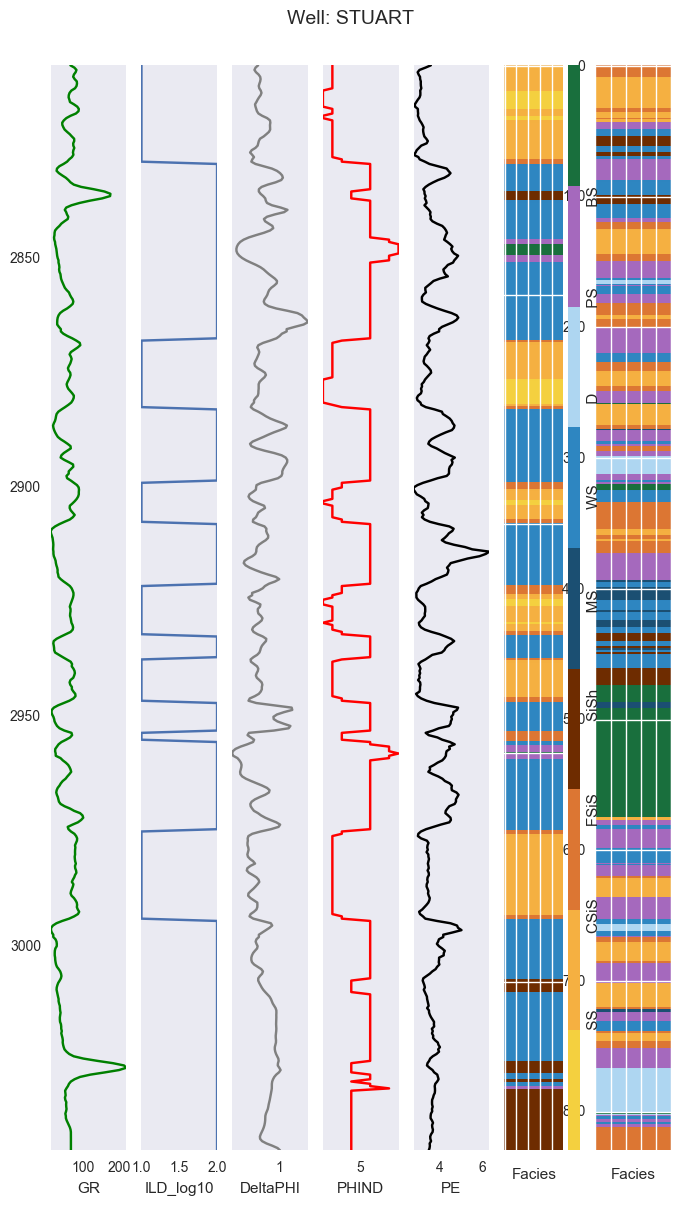

In [41]:
make_facies_log_plot(
    final_prediction[final_prediction['Well Name'] == 'STUART'],
    facies_colors, gcc_test)

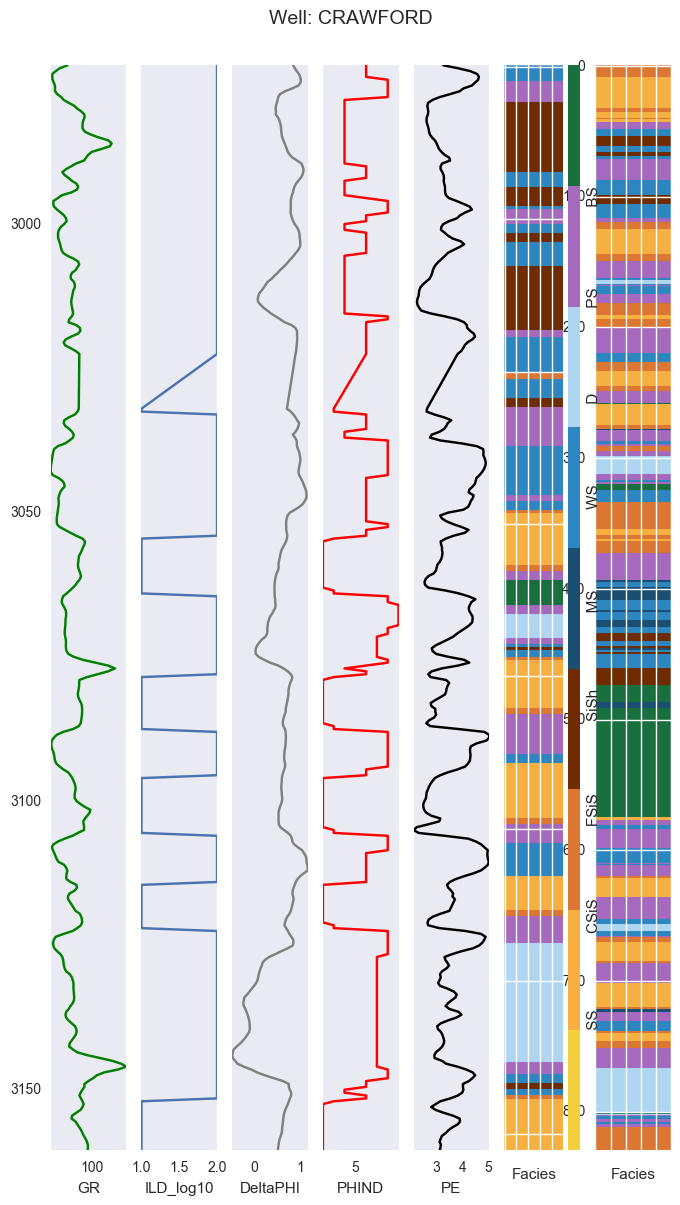

In [43]:
make_facies_log_plot(
    final_prediction[final_prediction['Well Name'] == 'CRAWFORD'],
    facies_colors, gcc_test)

In [40]:
def make_facies_log_plot(logs, facies_colors, comparison):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster1=np.repeat(np.expand_dims(comparison['Facies'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 14))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.NM_M, logs.Depth, '-')
    ax[2].plot(logs.ILD_log10, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.Facies  , logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    im=ax[6].imshow(cluster1, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.NM_M.min(), logs.NM_M.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.Facies.min(),logs.Facies.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    plt.show()